# Install Transformers Library

In [2]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
     |████████████████████████████████| 3.3 MB 32.0 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import transformers
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
import matplotlib.pyplot as plt

# specify GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load Dataset

In [8]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/small_dataset1.xlsx")
df.head()

,class,Symptom Severity,Delusion Score,text
0,patient,72,12,I would wake up greet my pet/friend use the ...
1,patient,92,22,"On a average Sunday I wake up, brush my teet..."
2,patient,64,4,Well This white lady moved in my hood an she...
3,control,0,0,sometimes when my family comes around and th...
4,patient,79,10,The thing that makes me the angriest is when...


In [9]:
df = df[df['class'] == "patient"] # filtering only the patient class as control is always 0

In [10]:
df.shape

(183, 4)

(array([ 8., 23., 24., 21., 21., 22., 24., 20., 14.,  6.]),
 array([ 35. ,  41.8,  48.6,  55.4,  62.2,  69. ,  75.8,  82.6,  89.4,
         96.2, 103. ]),
 <a list of 10 Patch objects>)

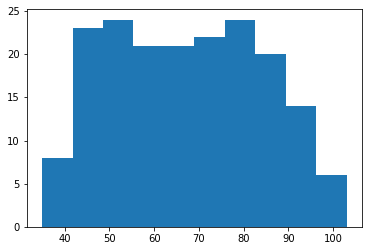

In [11]:
# check class distribution
plt.hist(df['Symptom Severity'])

# Split train dataset into train, validation and test sets

In [14]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['Symptom Severity'], 
                                                                    random_state=42, 
                                                                    test_size=0.3)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5)

### Checking if similar distribution

(array([4., 4., 5., 3., 2., 1., 1., 4., 2., 2.]),
 array([ 44. ,  49.7,  55.4,  61.1,  66.8,  72.5,  78.2,  83.9,  89.6,
         95.3, 101. ]),
 <a list of 10 Patch objects>)

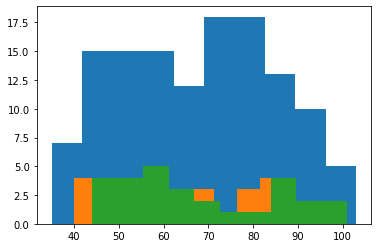

In [15]:
plt.hist(train_labels)
plt.hist(val_labels)
plt.hist(test_labels)

# Import GPT Model and GPT Tokenizer

In [17]:

# Load the GPT tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# import GPT pretrained model
gpt_config = GPT2Config.from_pretrained('gpt2', num_classes=1, pad_token=tokenizer.eos_token, pad_token_id=tokenizer.eos_token_id)
gpt = GPT2ForSequenceClassification.from_pretrained('gpt2', config=gpt_config)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
tokenizer.pad_token = tokenizer.eos_token
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[5661, 318, 257, 275, 861, 2746, 11808, 50256, 50256, 50256], [732, 481, 3734, 12, 83, 1726, 257, 275, 861, 2746]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

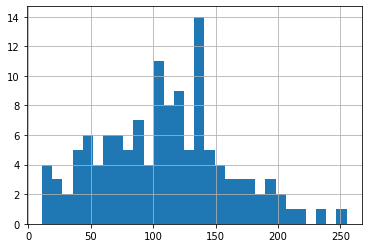

In [21]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [22]:
max_seq_len = 200

In [23]:

train_text

344      Sleeping late til maybe 1:-3: o'clock and wa...
305    One of the most perfectly terrible to horrific...
168      The thing that marke me anger is the time I ...
332      Injustice makes unhappy. When people dont ta...
60       What makes me angry is when soneboy tries to...
                             ...                        
197      My average Sunday is I would go to church or...
33       My Sundays usalyy consist of relaxation and ...
179     Wakeing up thanking God for that day takeing ...
365      Sunday Afternoon, the food is cooking, the f...
192      My average Sunday is like waking up thanking...
Name: text, Length: 128, dtype: object

In [24]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [26]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.float32)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.float32)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.float32)

# Create DataLoaders

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [28]:
# # freeze parameters except the regression head
# for name, param in gpt.named_parameters():
#     if name in ['transformer.ln_f.weight', 'transformer.ln_f.bias', 'score.weight']:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# Define Model Architecture

In [ ]:
class GPT_Arch(nn.Module):

    def __init__(self, gpt):
      
      super(GPT_Arch, self).__init__()

      self.gpt = gpt

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      x = self.gpt(input_ids=sent_id, attention_mask=mask)

      return x[0]

In [ ]:
# pass the pre-trained BERT to our define architecture
model = GPT_Arch(gpt)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-3)

## Loss Function

In [ ]:
# loss function
loss_fn  = nn.MSELoss()

# number of training epochs
epochs = 50

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # print(preds)
    # compute the loss between actual and predicted values
    loss = loss_fn(preds[:, 0], labels)
    # print(loss)
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = loss_fn(preds[:, 0],labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50

Evaluating...

Training Loss: 3527.997
Validation Loss: 2526.277

 Epoch 2 / 50

Evaluating...

Training Loss: 2135.883
Validation Loss: 1329.237

 Epoch 3 / 50

Evaluating...

Training Loss: 1022.181
Validation Loss: 652.155

 Epoch 4 / 50

Evaluating...

Training Loss: 476.329
Validation Loss: 445.281

 Epoch 5 / 50

Evaluating...

Training Loss: 451.523
Validation Loss: 514.737

 Epoch 6 / 50

Evaluating...

Training Loss: 451.442
Validation Loss: 601.043

 Epoch 7 / 50

Evaluating...

Training Loss: 452.614
Validation Loss: 576.857

 Epoch 8 / 50

Evaluating...

Training Loss: 463.853
Validation Loss: 491.810

 Epoch 9 / 50

Evaluating...

Training Loss: 393.223
Validation Loss: 444.053

 Epoch 10 / 50

Evaluating...

Training Loss: 367.776
Validation Loss: 426.136

 Epoch 11 / 50

Evaluating...

Training Loss: 407.585
Validation Loss: 421.960

 Epoch 12 / 50

Evaluating...

Training Loss: 343.392
Validation Loss: 415.884

 Epoch 13 / 50

Evaluating...

Training Los

In [ ]:
import gc
gc.collect()

84

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [ ]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()[:, 0]

In [ ]:
preds

array([62.667835, 60.672356, 64.89391 , 67.88863 , 65.02994 , 71.63068 ,
       66.96915 , 71.43838 , 57.2656  , 61.17024 , 41.606632, 65.22812 ,
       83.2293  , 66.26175 , 71.63068 , 52.7983  , 65.76701 , 65.10782 ,
       57.79576 , 59.146282, 66.7883  , 71.66714 , 68.27609 , 73.49956 ,
       64.28841 , 68.1477  , 67.339485, 64.925156, 62.86543 , 71.09726 ],
      dtype=float32)

In [ ]:
# model's performance
print(f"MSE: {mean_squared_error(test_y, preds)}\n MAE: {mean_absolute_error(test_y, preds)} \n R2: {r2_score(test_y, preds)}")


MSE: 293.84613037109375
 MAE: 14.1010160446167 
 R2: -0.08788919753795743


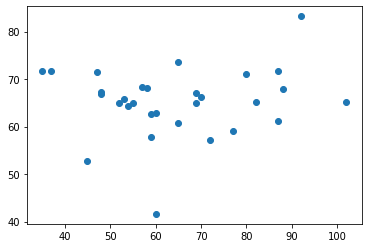

In [ ]:
plt.scatter(test_y, preds)